In [1]:
import sklearn
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [3]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [4]:

def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    # torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
    
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(np.array(x))
        y_train.extend(np.array(y))
        x_train_timestamp.extend(np.array(timestamp_train))


    x_train = np.array(x_train).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    x_train_timestamp = np.array(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(np.array(x))
        y_test.extend(np.array(y))
        x_test_timestamp.extend(timestamp)

    x_test = np.array(x_test).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    x_test_timestamp = np.array(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = np.array(x_train).reshape(x_train.shape[0], 1)
    y_train = np.array(y_train).reshape(-1,)
    x_train_timestamp = np.array(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = np.array(x_test).reshape(x_test.shape[0], 1)
    y_test = np.array(y_test).reshape(-1,)
    x_test_timestamp = np.array(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [5]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time = dataset_loader(appliances, train, test)

(53456, 1) (53456,) (53456, 1) (16781, 1) (16781,) (16781, 1)


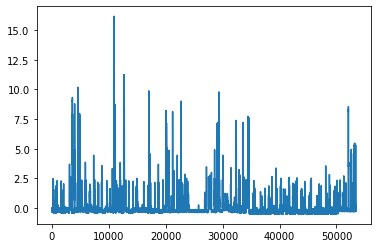

In [6]:
print(x_train.shape, y_train.shape, x_train_timestamp.shape, x_test.shape, y_test.shape, x_test_timestamp.shape)
plt.plot(x_train)

In [9]:
x_train_full = np.concatenate((x_train, x_train_timestamp),axis=1)
x_test_full = np.concatenate((x_test, x_test_timestamp),axis=1)
x_train_full.shape, x_test_full.shape

((53456, 2), (16781, 2))

## MLP

In [97]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(20,), random_state=0, max_iter=1000, shuffle=False).fit(x_train_full, y_train)

In [98]:
y_mean = mlp_model.predict(x_test_full)

In [99]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
mae = np.mean(np.abs(np.array(y_test) - y_mean))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  47.3928473812195
RMSE:  57.621937


: 

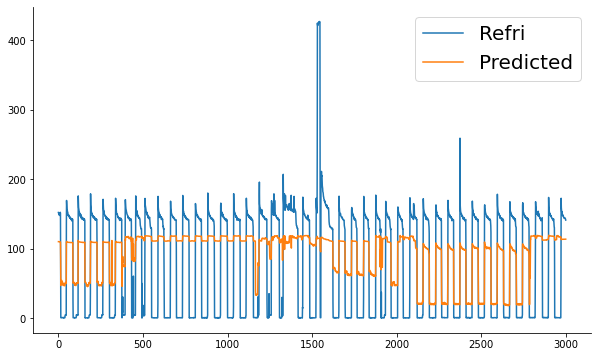

In [96]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("gp_ref_full_rbf_per_rbf_actdims.png", bbox_inches="tight")

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0).fit(x_train_full, y_train)

In [86]:
y_mean = regr.predict(x_test_full)

In [87]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
mae = np.mean(np.abs(np.array(y_test) - y_mean))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  30.108734347158496
RMSE:  57.187683


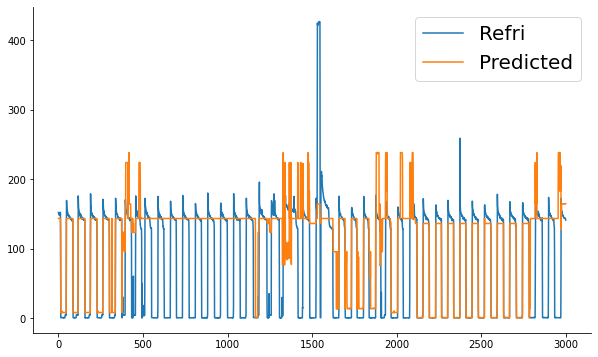

In [88]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("gp_ref_full_rbf_per_rbf_actdims.png", bbox_inches="tight")

## XG Boost

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
xgboost_model = GradientBoostingRegressor(**params).fit(x_train_full, y_train)

In [78]:
y_mean = xgboost_model.predict(x_test_full)

In [79]:
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
mae = np.mean(np.abs(np.array(y_test) - y_mean))
rms = errors.rmse(jnp.array(y_test), y_mean)

print("MAE: ", mae)
print("RMSE: ", rms)

MAE:  36.82532786988182
RMSE:  60.214664


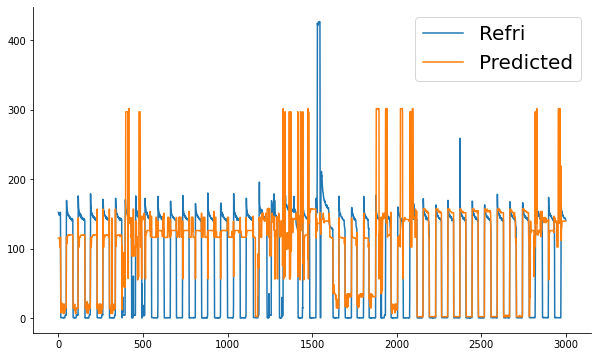

In [80]:
idx = 3000
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("gp_ref_full_rbf_per_rbf_actdims.png", bbox_inches="tight")